In [1]:
import numpy as np
import scipy as sp
from scipy import optimize
from scipy import stats
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def dilser(low=0.001, limit=100., dilfactor=2.):
    '''returns a numpy array dilution series from low to limit'''
    #replace this with a generator/iterator someday
    a = [low]
    while a[-1] <= limit:
        a.append(a[len(a)-1]*dilfactor)
    return np.array(a)

In [3]:
def binterval(k):
    '''takes apparent binding constent and builds lig series around it (2 log intervals on either end)'''
    low = (1/k)/1000
    limit = (1/k)*100
    return dilser(low=low,limit=limit)

In [4]:
def loguniform(low=0, high=1, size=None, base=np.exp(1)):
    return np.power(base, np.random.uniform(low, high, size))

In [5]:
def randomparms(pop):
    return ((np.random.lognormal(size=4)*np.random.choice(pop,4)) * (loguniform(size=4)/10))

In [6]:
def guessgen(length,lowmag=-3,himag=3,base=10):
    return tuple(lognuniform(low=lowmag,high=himag,base=base) for i in range(length))

In [7]:
def colroots(data,ligs): 
    holder = []
    for i in range(len(ligs)):
        temp = data[:,i]
        roots,counts = np.unique(temp,return_counts=True)
        posroots = roots[roots>0]
        poscounts = counts[roots>0]
        clctd = np.stack((posroots,poscounts),axis=1)
        clctd = clctd[(-1*clctd[:,1]).argsort()]
        holder.append(clctd[:3]) #only take top 3 (or fewer) guesses
    return holder

In [8]:
def wymsol(var,parm,rtot,ltot):
    
    k11 = parm[0]
    k21 = parm[1]
    k22 = parm[2]
    l20 = parm[3]
    
    (L, M, MM, ML, MML, MMLL) = var
    
    eq1 = (M + 2*MM + ML + 2*MML + 2*MMLL) - rtot
    eq2 = (L + ML + MML + 2*MMLL) - ltot
    eq3 = (l20 * M*M) - MM
    eq4 = (k11 * L * M) - ML
    eq5 = (l20 * k21 * M*M * L) - MML
    eq6 = (k22 * L * MML) - MMLL
    
    return np.array([eq1,eq2,eq3,eq4,eq5,eq6])

In [9]:
def wym_obj(guess,model,data,ligs,rtot):
    datac = np.concatenate(data)
    return (model(guess,ligs,rtot)-datac)

def fit_wym(guess,model,data,ligs,rtot,bnds,loss='linear'):
        return sp.optimize.least_squares(wym_obj,guess,args=(model,data,ligs,rtot),bounds=bnds,method='trf',ftol=1e-14,gtol=1e-14,xtol=1e-14,loss=loss)

In [10]:
def wymfunc(parm,lig,rtot):
    '''
    Model function for dimerizing, single-site receptors as derived in
    (Wyman and Gill, Binding and Linkage, 1990) and used by
    (Macdonald and Pike, ...EGF-binding...negative cooperativity...aggregating system, 2008).
    Takes numpy array of parameters [k11,k21,k22,l20], numpy array of free ligand concentrations,
    and total receptor concentration. Returns the fraction of receptor bound to ligand.

    To generate a data set, iterate over an array of desired receptor concentrations, e.g.:
    [wymfunc(parm,lig,i) for i in array_of_rtots]

    For use in curve fitting an objective function for use with scipy.optimize.least_squares
    is readily constructed as: (wymfun(parm_guess,lig,rtot) - actual_data)
    '''

    #ensure dimension/broadcasting compatibility of inputs
    if ((rtot.ndim > 0) and (rtot.ndim != lig.ndim)):
        rtot = rtot[:,None] #adds dimension so that it can be broadcast
    else:
        rtot = rtot

    #unpack parameters
    k11 = parm[0]
    k21 = parm[1]
    k22 = parm[2]
    l20 = parm[3]

    ### START MODEL FUNCTION ###

    #calculate concentration of free (unoccupied) receptor
    rfree = (((-1 - k11*lig)) + \
    ((np.square((1 + k11*lig)) + \
    8.*l20*rtot*(1 + k21*lig + k21*k22*(np.square(lig)))))**0.5) \
    / (4*l20*(1 + k21*lig + k21*k22*(np.square(lig))))

    #calculate bound fraction
    bfrac = (k11*lig + l20*k21*rfree*lig + \
    2*l20*k21*k22*rfree*(np.square(lig))) \
    / (1 + 2*l20*rfree + k11*lig + \
    2*l20*k21*rfree*lig + 2*l20*k21*k22*rfree*(np.square(lig)))

    ### END MODEL FUNCTION ###

    #flatten output
    if ((rtot.ndim > 0) and (rtot.ndim != lig.ndim)):
        return bfrac.flatten()
    elif (rtot.ndim == 0):
        return bfrac.flatten()
    else:
        return np.concatenate(bfrac)

In [11]:
def wymfunc_fix(parm,lig,rtot):
    '''
    Model function for dimerizing, single-site receptors as derived in
    (Wyman and Gill, Binding and Linkage, 1990) and used by
    (Macdonald and Pike, ...EGF-binding...negative cooperativity...aggregating system, 2008).
    Takes numpy array of parameters [k11,k21,k22,l20], numpy array of free ligand concentrations,
    and total receptor concentration. Returns the fraction of receptor bound to ligand.

    To generate a data set, iterate over an array of desired receptor concentrations, e.g.:
    [wymfunc(parm,lig,i) for i in array_of_rtots]

    For use in curve fitting an objective function for use with scipy.optimize.least_squares
    is readily constructed as: (wymfun(parm_guess,lig,rtot) - actual_data)
    '''

    #ensure dimension/broadcasting compatibility of inputs
    if ((rtot.ndim > 0) and (rtot.ndim != lig.ndim)):
        rtot = rtot[:,None] #adds dimension so that it can be broadcast
    else:
        rtot = rtot

    #unpack parameters
    k11 = parm[0]
    k21 = parm[1]
    k22 = k21/4.
    l20 = parm[2]

    ### START MODEL FUNCTION ###

    #calculate concentration of free (unoccupied) receptor
    rfree = (((-1 - k11*lig)) + \
    ((np.square((1 + k11*lig)) + \
    8.*l20*rtot*(1 + k21*lig + k21*k22*(np.square(lig)))))**0.5) \
    / (4*l20*(1 + k21*lig + k21*k22*(np.square(lig))))

    #calculate bound fraction
    bfrac = (k11*lig + l20*k21*rfree*lig + \
    2*l20*k21*k22*rfree*(np.square(lig))) \
    / (1 + 2*l20*rfree + k11*lig + \
    2*l20*k21*rfree*lig + 2*l20*k21*k22*rfree*(np.square(lig)))

    ### END MODEL FUNCTION ###

    #flatten output
    if ((rtot.ndim > 0) and (rtot.ndim != lig.ndim)):
        return bfrac.flatten()
    elif (rtot.ndim == 0):
        return bfrac.flatten()
    else:
        return np.concatenate(bfrac)

In [12]:
ligconcs = dilser(low=1e-4,limit=1e4,dilfactor=2)

In [13]:
rtotwym = np.array([1e-3,1e-2,1e-1,1e0,1e1])

In [15]:
parms = np.array([randomparms(np.array([0.001,0.01,.1,1.,10.,100.,1000.,10000.])) for i in range(1000)])

In [16]:
parms_nocoop = parms.copy()
parms_nocoop[:,2] = parms_nocoop[:,1]/4

In [17]:
computed_bind = np.array([[wymfunc(j,ligconcs,i) for i in rtotwym] for j in parms_nocoop])

In [18]:
computed_bind.shape

(1000, 5, 28)

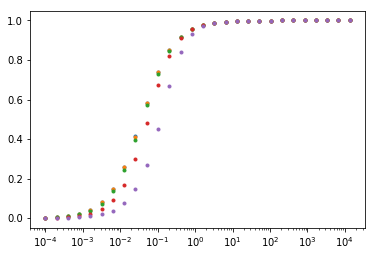

In [19]:
for i in computed_bind[54]:
    plt.semilogx(ligconcs,i,'.')

[  2.75620718e+01   1.67759787e-03   4.19399469e-04   7.55672543e-01]


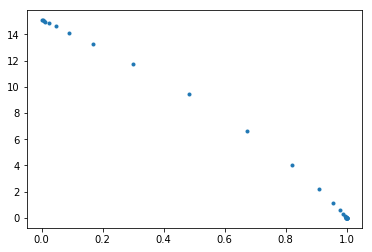

In [21]:
for i in range(3,4):
    ind = 54
    rebnd = computed_bind[ind] * rtotwym.reshape(-1,1)
    plt.plot(rebnd[i],(rebnd[i]/ligconcs),'.')
    print(parms_nocoop[ind])

In [22]:
lsbnds = (tuple(1e-6 for i in range(4)),tuple(1e6 for i in range(4)))
lsbnds_fix = (tuple(1e-6 for i in range(3)),tuple(1e6 for i in range(3)))

In [23]:
fixed_guesses = np.concatenate([parms_nocoop[:,0:2],parms_nocoop[:,3:4]],axis=1)

In [390]:
ind = 0
dat = computed_bind[ind]
guess = fixed_guesses[ind]
rtot = rtotwym.reshape(-1,1)

In [391]:
fit = fit_wym(guess,wymfunc_fix,dat,ligconcs,rtot,lsbnds_fix)

In [392]:
fit.x

array([  8.32708233e-02,   6.28690016e-01,   1.35008217e+03])

In [393]:
guess

array([  8.32708233e-02,   6.28690016e-01,   1.35008217e+03])

In [394]:
ndata = np.abs(dat + np.random.normal(loc=0,scale=0.05,size=(data.shape)))

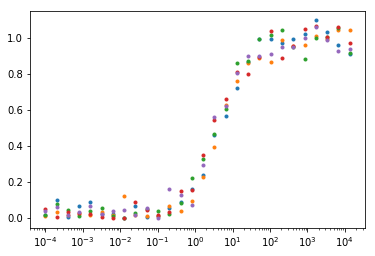

In [395]:
for i in ndata:
    plt.semilogx(ligconcs,i,'.')

In [396]:
nfit = fit_wym(guess,wymfunc_fix,ndata,ligconcs,rtot,lsbnds_fix)

In [397]:
nfit.x

array([  0.21175264,   0.62047947,  13.5829534 ])

In [398]:
def ftest(fit1,fit2):
    '''
    fit1 is fit from simpler model
    '''

    SS1 = np.sum(np.square(fit1.fun))
    SS2 = np.sum(np.square(fit2.fun))

    DF1 = fit1.fun.shape[0] - fit1.x.shape[0]
    DF2 = fit2.fun.shape[0] - fit2.x.shape[0]

    F = ((SS1-SS2)/(DF1-DF2))/(SS2/DF2)

    p = sp.stats.f.sf(F,(DF1-DF2),DF2)

    return (SS1,SS2,DF1,DF2,F,p)

In [399]:
ncb5 = np.abs(computed_bind + np.random.normal(loc=0,scale=0.025,size=(computed_bind.shape)))

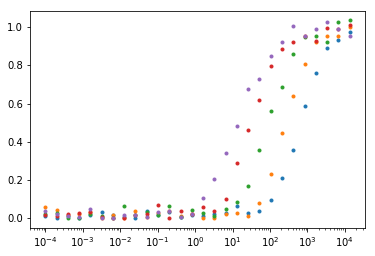

In [400]:
for i in ncb5[1]:
    plt.semilogx(ligconcs,i,'.')

In [401]:
ligset = np.array([ligconcs for i in range(5)])

In [410]:
fixed_fits = [fit_wym(fixed_guesses[i],wymfunc_fix,ncb5[i],ligset,rtot,lsbnds_fix,loss='soft_l1') for i in range(250)]

In [411]:
coop_fits = [fit_wym(parms[i],wymfunc,ncb5[i],ligset,rtot,lsbnds,loss='soft_l1') for i in range(250)]

In [412]:
np.sum(np.array([ftest(fixed_fits[i],coop_fits[i])[-1] for i in range(250)]) < 0.05)

16

In [413]:
nonoise_fixed_fits = [fit_wym(fixed_guesses[i],wymfunc_fix,computed_bind[i],ligset,rtot,lsbnds_fix) for i in range(100)]

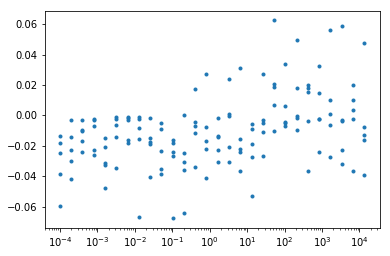

In [414]:
plt.semilogx(np.concatenate(ligset),fixed_fits[1].fun,'.')

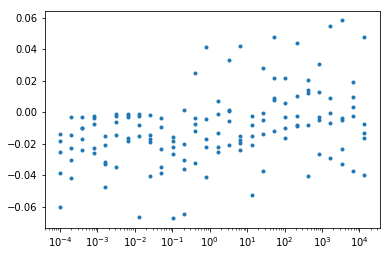

In [415]:
plt.semilogx(np.concatenate(ligset),coop_fits[1].fun,'.')

In [416]:
np.where(np.array([ftest(fixed_fits[i],coop_fits[i])[-1] for i in range(250)]) < 0.05)

(array([  1,   9,  61,  82,  84,  88, 109, 117, 136, 165, 167, 205, 221,
        233, 238, 245]),)

In [421]:
fixed_fits[9].x

array([ 0.47174956,  6.7874556 ,  0.079881  ])

In [422]:
parms_nocoop[9]

array([ 0.45134283,  7.94357484,  1.98589371,  0.05612849])

In [423]:
coop_fits[9].x

array([  0.47429388,  10.93751302,   1.3598921 ,   0.05614899])